In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
class VRPDP_ACO:
    def __init__(self, alpha=1, beta=2, rho=0.5, Q=100, num_ants=5, num_iterations=100):
        # ACO algorithm parameters
        self.alpha = alpha              # Influence of pheromone
        self.beta = beta                # Influence of heuristic (1 / travel time)
        self.rho = rho                  # Evaporation rate
        self.Q = Q                      # Pheromone deposit factor
        self.num_ants = num_ants
        self.num_iterations = num_iterations

    def _compute_route_distance(self, route, distance_matrix, customer_index):
        """Compute total distance of a given route based on heuristic matrix."""
        total_distance = 0
        for i in range(len(route) - 1):
            from_node = route[i][0]
            to_node = route[i][1]
            from_idx = customer_index[from_node]
            to_idx = customer_index[to_node]
            total_distance += distance_matrix[from_idx][to_idx]
        return total_distance

    def _compute_distance_matrix(self, all_nodes, travel_times):
        """Compute and return the heuristic matrix (1 / travel time) between all pairs of nodes."""
        n = len(all_nodes)
        distance_matrix = np.zeros((n, n))
        index_map = {node: idx for idx, node in enumerate(all_nodes)}

        # Only compute for (i ≠ j) once per pair, use symmetry if available
        for i, from_node in enumerate(all_nodes):
            for j, to_node in enumerate(all_nodes):
                if i == j:
                    continue
                if (from_node, to_node) in travel_times:
                    travel_time = travel_times[(from_node, to_node)]
                elif (to_node, from_node) in travel_times:
                    travel_time = travel_times[(to_node, from_node)]
                else:
                    travel_time = float('inf')  # If missing, assume unreachable
                distance_matrix[i][j] = 1 / travel_time
        return distance_matrix

    def _choose_next_customer(self, current, candidates, pheromone_matrix, distance_matrix, customer_index):
        """
        Select the next customer using probabilistic transition rules.

        probabilities[i] ∝ pheromone^alpha * heuristic^beta
        where:
          - pheromone = desirability based on past experience
          - heuristic = 1 / travel time = closeness
        """
        probabilities = np.zeros(len(candidates))
        for i, cust in enumerate(candidates):
            i_from = customer_index[current]
            i_to = customer_index[cust]
            pheromone = pheromone_matrix[i_from][i_to]
            heuristic = distance_matrix[i_from][i_to]
            probabilities[i] = (pheromone ** self.alpha) * (heuristic ** self.beta)
        probabilities /= probabilities.sum()
        return np.random.choice(candidates, p=probabilities)

    def solve(self, depot, customers, vehicles, travel_times):
        # ============================
        # Initialization of Structures
        # ============================

        all_nodes = ['Depot'] + list(customers.keys())
        customer_index = {customer: idx for idx, customer in enumerate(all_nodes)}
        n = len(all_nodes)

        # Initialize pheromone and heuristic matrices
        pheromone_matrix = np.ones((n, n))
        distance_matrix = self._compute_distance_matrix(all_nodes, travel_times)

        best_route = None
        best_distance = float('inf')

        # ====================================
        # Main ACO Optimization Loop
        # ====================================

        for iteration in range(self.num_iterations):
            ant_routes = []

            for _ in range(self.num_ants):
                route = []
                current_location = 'Depot'
                capacity_remaining = vehicles['1']['capacity']
                unvisited_customers = list(customers.keys())

                while unvisited_customers:
                    feasible_customers = [c for c in unvisited_customers if customers[c]['demand'] <= capacity_remaining]
                    if not feasible_customers:
                        break

                    next_customer = self._choose_next_customer(
                        current_location,
                        feasible_customers,
                        pheromone_matrix,
                        distance_matrix,
                        customer_index
                    )
                    route.append((current_location, next_customer))
                    current_location = next_customer
                    capacity_remaining -= customers[next_customer]['demand']
                    unvisited_customers.remove(next_customer)

                # Return to depot
                route.append((current_location, 'Depot'))
                ant_routes.append(route)

            # Pheromone evaporation
            pheromone_matrix *= (1 - self.rho)

            # Pheromone update based on ant solutions
            for route in ant_routes:
                route_distance = self._compute_route_distance(route, distance_matrix, customer_index)
                deposit = self.Q / route_distance
                for i in range(len(route) - 1):
                    from_idx = customer_index[route[i][0]]
                    to_idx = customer_index[route[i][1]]
                    pheromone_matrix[from_idx][to_idx] += deposit

                if route_distance < best_distance:
                    best_distance = route_distance
                    best_route = route

        return best_route

    def solve_with_time(self, depot, customers, vehicles, travel_times):
        # ============================
        # Initialization of Structures
        # ============================

        all_nodes = ['Depot'] + list(customers.keys())
        customer_index = {customer: idx for idx, customer in enumerate(all_nodes)}
        n = len(all_nodes)

        # Initialize pheromone and heuristic matrices
        pheromone_matrix = np.ones((n, n))
        distance_matrix = self._compute_distance_matrix(all_nodes, travel_times)

        best_route = None
        best_distance = float('inf')

        # ====================================
        # Main ACO Optimization Loop
        # ====================================

        for iteration in range(self.num_iterations):
            ant_routes = []

            for _ in range(self.num_ants):
                route = []
                current_location = 'Depot'
                current_time = 0
                capacity_remaining = vehicles['1']['capacity']
                unvisited_customers = list(customers.keys())

                while unvisited_customers:
                    feasible_customers = []
                    for c in unvisited_customers:
                        if customers[c]['demand'] > capacity_remaining:
                            continue
                        travel_time = travel_times[(current_location, c)]
                        arrival_time = current_time + travel_time
                        if arrival_time > customers[c]['time_window'][1]:
                            continue
                        feasible_customers.append(c)

                    if not feasible_customers:
                        break

                    next_customer = self._choose_next_customer(
                        current_location,
                        feasible_customers,
                        pheromone_matrix,
                        distance_matrix,
                        customer_index
                    )
                    route.append((current_location, next_customer))

                    travel_time = travel_times[(current_location, next_customer)]
                    current_time += travel_time

                    current_location = next_customer
                    capacity_remaining -= customers[next_customer]['demand']
                    unvisited_customers.remove(next_customer)

                # Return to depot
                route.append((current_location, 'Depot'))
                ant_routes.append(route)

            # Pheromone evaporation
            pheromone_matrix *= (1 - self.rho)

            # Pheromone update based on ant solutions
            for route in ant_routes:
                route_distance = self._compute_route_distance(route, distance_matrix, customer_index)
                deposit = self.Q / route_distance
                for i in range(len(route) - 1):
                    from_idx = customer_index[route[i][0]]
                    to_idx = customer_index[route[i][1]]
                    pheromone_matrix[from_idx][to_idx] += deposit

                if route_distance < best_distance:
                    best_distance = route_distance
                    best_route = route

        return best_route

In [ ]:
# ================
# Sample Usage
# ================

depot = (40.7128, -74.0060)
customers = {
    'A': {'location': (40.7291, -74.0113), 'demand': 5, 'time_window': (9, 12)},
    'B': {'location': (40.7429, -73.9922), 'demand': 3, 'time_window': (10.5, 13.5)},
    'C': {'location': (40.7180, -73.9962), 'demand': 2, 'time_window': (13, 16)},
}
vehicles = {
    '1': {'capacity': 10, 'location': depot},
    '2': {'capacity': 8, 'location': depot},
}
travel_times = {
    ('Depot', 'A'): 15, ('Depot', 'B'): 20, ('Depot', 'C'): 10,
    ('A', 'Depot'): 15, ('A', 'B'): 25, ('A', 'C'): 18,
    ('B', 'Depot'): 20, ('B', 'A'): 25, ('B', 'C'): 12,
    ('C', 'Depot'): 10, ('C', 'A'): 18, ('C', 'B'): 12,
}

aco_solver = VRPDP_ACO()
best_route = aco_solver.solve(depot, customers, vehicles, travel_times)

print("Best Route:")
for step in best_route:
    print(step)

Best Route:
('Depot', np.str_('C'))
(np.str_('C'), np.str_('A'))
(np.str_('A'), np.str_('B'))
(np.str_('B'), 'Depot')


In [ ]:
# Parse solomon dataset into sample format
def parse_solomon(filepath):
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]

    # Vehicle capacity
    capacity = 200
    for i, line in enumerate(lines):
        if "CAPACITY" in line and i+1 < len(lines):
            try:
                capacity = int(lines[i+1].split()[-1])
                break
            except (ValueError, IndexError):
                pass

    # Depot = Customer 0
    depot = (40.0, 50.0)
    for line in lines:
        parts = line.split()
        if len(parts) >= 3 and parts[0] == "0":
            try:
                depot = (float(parts[1]), float(parts[2]))
                break
            except (ValueError, IndexError):
                pass

    # Parse customers
    customers = {}
    for line in lines:
        parts = line.split()
        if len(parts) < 6:
            continue

        if parts[0].isdigit() and parts[0] != "0":
            try:
                customers[f"C{parts[0]}"] = {
                    'location': (float(parts[1]), float(parts[2])),
                    'demand': int(parts[3]),
                    'time_window': (int(parts[4]), int(parts[5]))
                }
            except (ValueError, IndexError):
                print(f"Skipping malformed customer line: {line}")
                continue

    # Create vehicles
    vehicles = {
        str(i+1): {'capacity': capacity, 'location': depot}
        for i in range(25)
    }

    return depot, customers, vehicles

# Compute travel time by Euclidean distance between 2 customers
def compute_travel_times(customers, depot):
    travel_times = {}
    all_nodes = ['Depot'] + list(customers.keys())

    for i in all_nodes:
        for j in all_nodes:
            if i == j:
                continue
            loc_i = depot if i == 'Depot' else customers[i]['location']
            loc_j = depot if j == 'Depot' else customers[j]['location']
            distance = math.sqrt((loc_i[0]-loc_j[0])**2 + (loc_i[1]-loc_j[1])**2)
            travel_times[(i, j)] = distance

    return travel_times

In [ ]:
def check_time(best_route, customers, travel_times):
    current_time = 0  # Start at depot at time 0
    feasible = True
    for from_node, to_node in best_route:
        travel_time = travel_times[(from_node, to_node)]
        current_time += travel_time
        if to_node != 'Depot':
            tw_start, tw_end = customers[to_node]['time_window']
            if current_time > tw_end:
                print(f"Time violation at {to_node}: Arrival {current_time} > TW end {tw_end}")
                return False
    return True

def check_capacity(best_route, customers, vehicles):
    total_demand = sum(customers[step[1]]['demand'] for step in best_route if step[1] != 'Depot')
    vehicle_capacity = vehicles['1']['capacity']
    if total_demand > vehicle_capacity:
        print(f"Capacity violation: demand {total_demand} > capacity {vehicle_capacity}")
        return False
    return True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_params(filename):
    filepath = f'/content/drive/My Drive/242/GTNC/{filename}'
    depot, customers, vehicles = parse_solomon(filepath)
    travel_times = compute_travel_times(customers, depot)
    print(f"{filename} dataset")
    return depot, customers, vehicles, travel_times

def test_ACO(method, depot, customers, vehicles, travel_times):
    count_true = 0
    count_false = 0

    for i in range(1, 11):
      print(f"Trial {i}")
      func = getattr(aco_solver, method)
      best_route = func(depot, customers, vehicles, travel_times)
      feasible_time = check_time(best_route, customers, travel_times)
      feasible_cap = check_capacity(best_route, customers, vehicles)
      print(f"Time window feasible: {feasible_time}")
      print(f"Vehicle capacity feasible: {feasible_cap}")
      if (feasible_time and feasible_cap):
        count_true += 1
      else:
        count_false += 1

    print(f"Number of valid/invalid routes: {count_true}/{count_false}\n")
    return best_route, feasible_time, feasible_cap

def plot_route(route, customers, depot):
    plt.figure(figsize=(10, 8))

    x_coords = [depot[0]]
    y_coords = [depot[1]]

    for step in route:
        if step[1] != 'Depot':
            x_coords.append(customers[step[1]]['location'][0])
            y_coords.append(customers[step[1]]['location'][1])

    x_coords.append(depot[0])
    y_coords.append(depot[1])

    plt.plot(x_coords, y_coords, 'g-', linewidth=1, alpha=0.7)  # Green path lines
    plt.plot(x_coords[-1], y_coords[-1], 'o', color='orange', markersize=10)  # Depot (end)

    plt.plot(x_coords[0], y_coords[0], 'o', color='orange', markersize=10, label='Depot')  # Depot (start)
    plt.plot(x_coords[1:-1], y_coords[1:-1], 'go', markersize=8, label='Customers')  # Customers

    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.title('Vehicle Routing Solution', fontsize=14)

    for step in route:
        if step[1] != 'Depot':
            plt.annotate(step[1],
                        (customers[step[1]]['location'][0], customers[step[1]]['location'][1]),
                        textcoords="offset points",
                        xytext=(0,5),
                        ha='center')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

c101.txt dataset
Trial 1
Time window feasible: True
Vehicle capacity feasible: True
Trial 2
Time violation at C5: Arrival 85.24122847484506 > TW end 67
Time window feasible: False
Vehicle capacity feasible: True
Trial 3
Time window feasible: True
Vehicle capacity feasible: True
Trial 4
Time violation at C5: Arrival 110.83502449935307 > TW end 67
Time window feasible: False
Vehicle capacity feasible: True
Trial 5
Time violation at C32: Arrival 107.28973515419574 > TW end 100
Time window feasible: False
Vehicle capacity feasible: True
Trial 6
Time violation at C20: Arrival 113.65152589493559 > TW end 73
Time window feasible: False
Vehicle capacity feasible: True
Trial 7
Time violation at C32: Arrival 117.85508878410158 > TW end 100
Time window feasible: False
Vehicle capacity feasible: True
Trial 8
Time window feasible: True
Vehicle capacity feasible: True
Trial 9
Time window feasible: True
Vehicle capacity feasible: True
Trial 10
Time window feasible: True
Vehicle capacity feasible: Tru

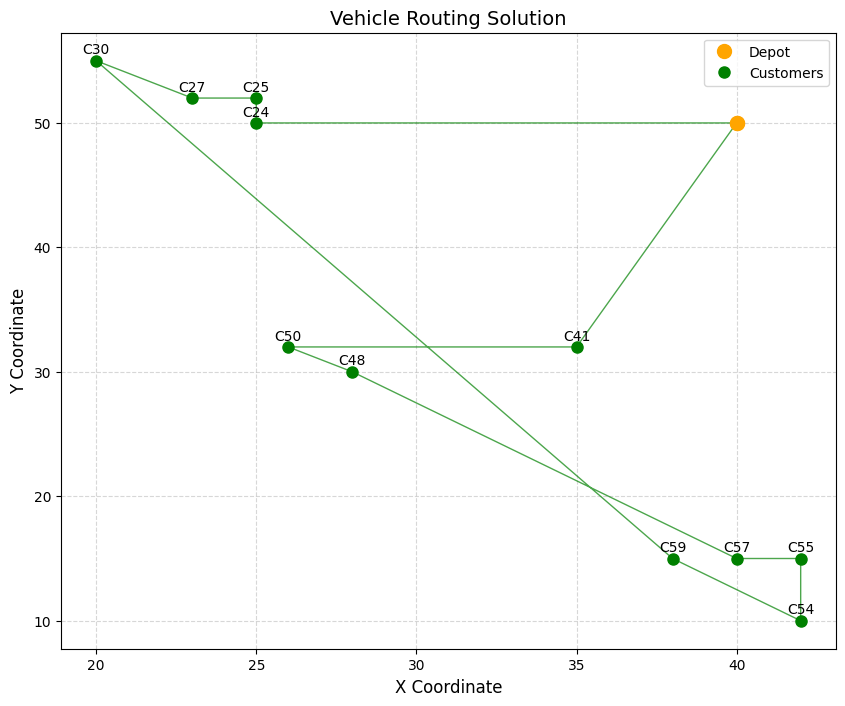

r101.txt dataset
Trial 1
Time violation at C27: Arrival 97.61550234805253 > TW end 47
Time window feasible: False
Vehicle capacity feasible: True
Trial 2
Time violation at C40: Arrival 99.44084402676118 > TW end 95
Time window feasible: False
Vehicle capacity feasible: True
Trial 3
Time violation at C83: Arrival 67.3574379305948 > TW end 54
Time window feasible: False
Vehicle capacity feasible: True
Trial 4
Time violation at C30: Arrival 110.17018237713872 > TW end 81
Time window feasible: False
Vehicle capacity feasible: True
Trial 5
Time violation at C31: Arrival 81.7065506164109 > TW end 60
Time window feasible: False
Vehicle capacity feasible: True
Trial 6
Time violation at C59: Arrival 74.77708763999662 > TW end 28
Time window feasible: False
Vehicle capacity feasible: True
Trial 7
Time violation at C45: Arrival 58.54960267788073 > TW end 42
Time window feasible: False
Vehicle capacity feasible: True
Trial 8
Time violation at C30: Arrival 94.8645596560871 > TW end 81
Time window f

In [ ]:
# Sử dụng hàm solve

filenames = ['c101.txt', 'r101.txt', 'rc101.txt']
for i, filename in enumerate(filenames):
    depot, customers, vehicles, travel_times = get_params(filename)
    best_route, feasible_time, feasible_cap = test_ACO('solve', depot, customers, vehicles, travel_times)

    if i != 0:
        continue

    while (not feasible_time or not feasible_cap):
        best_route = aco_solver.solve(depot, customers, vehicles, travel_times)
        feasible_time = check_time(best_route, customers, travel_times)
        feasible_cap = check_capacity(best_route, customers, vehicles)

    print(best_route[0][0], end="")
    for route in best_route:
        print(f"-> {str(route[1])}", end="")

    plot_route(best_route, customers, depot)

c101.txt dataset
Trial 1
Time window feasible: True
Vehicle capacity feasible: True
Trial 2
Time window feasible: True
Vehicle capacity feasible: True
Trial 3
Time window feasible: True
Vehicle capacity feasible: True
Trial 4
Time window feasible: True
Vehicle capacity feasible: True
Trial 5
Time window feasible: True
Vehicle capacity feasible: True
Trial 6
Time window feasible: True
Vehicle capacity feasible: True
Trial 7
Time window feasible: True
Vehicle capacity feasible: True
Trial 8
Time window feasible: True
Vehicle capacity feasible: True
Trial 9
Time window feasible: True
Vehicle capacity feasible: True
Trial 10
Time window feasible: True
Vehicle capacity feasible: True
Number of valid/invalid routes: 10/0

Depot-> C10-> C11-> C13-> C17-> C42-> C46-> C55-> C54-> C59-> C4-> C9-> Depot

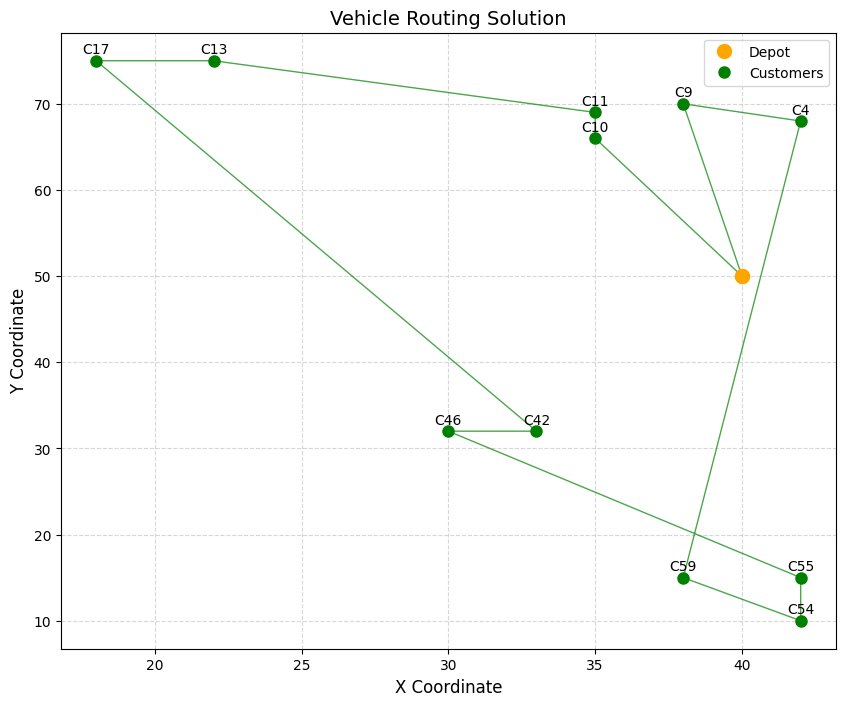

r101.txt dataset
Trial 1
Time window feasible: True
Vehicle capacity feasible: True
Trial 2
Time window feasible: True
Vehicle capacity feasible: True
Trial 3
Time window feasible: True
Vehicle capacity feasible: True
Trial 4
Time window feasible: True
Vehicle capacity feasible: True
Trial 5
Time window feasible: True
Vehicle capacity feasible: True
Trial 6
Time window feasible: True
Vehicle capacity feasible: True
Trial 7
Time window feasible: True
Vehicle capacity feasible: True
Trial 8
Time window feasible: True
Vehicle capacity feasible: True
Trial 9
Time window feasible: True
Vehicle capacity feasible: True
Trial 10
Time window feasible: True
Vehicle capacity feasible: True
Number of valid/invalid routes: 10/0

Depot-> C87-> C95-> C49-> C19-> C24-> C80-> C77-> C1-> C70-> C58-> Depot

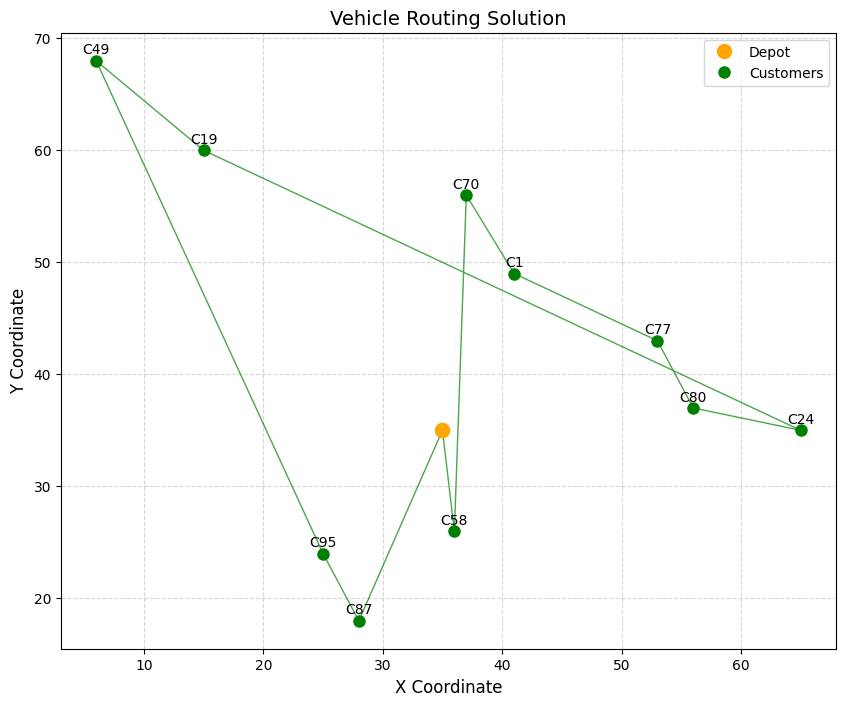

rc101.txt dataset
Trial 1
Time window feasible: True
Vehicle capacity feasible: True
Trial 2
Time window feasible: True
Vehicle capacity feasible: True
Trial 3
Time window feasible: True
Vehicle capacity feasible: True
Trial 4
Time window feasible: True
Vehicle capacity feasible: True
Trial 5
Time window feasible: True
Vehicle capacity feasible: True
Trial 6
Time window feasible: True
Vehicle capacity feasible: True
Trial 7
Time window feasible: True
Vehicle capacity feasible: True
Trial 8
Time window feasible: True
Vehicle capacity feasible: True
Trial 9
Time window feasible: True
Vehicle capacity feasible: True
Trial 10
Time window feasible: True
Vehicle capacity feasible: True
Number of valid/invalid routes: 10/0

Depot-> C80-> C91-> C70-> C100-> C93-> C71-> C67-> C34-> C32-> C50-> C89-> Depot

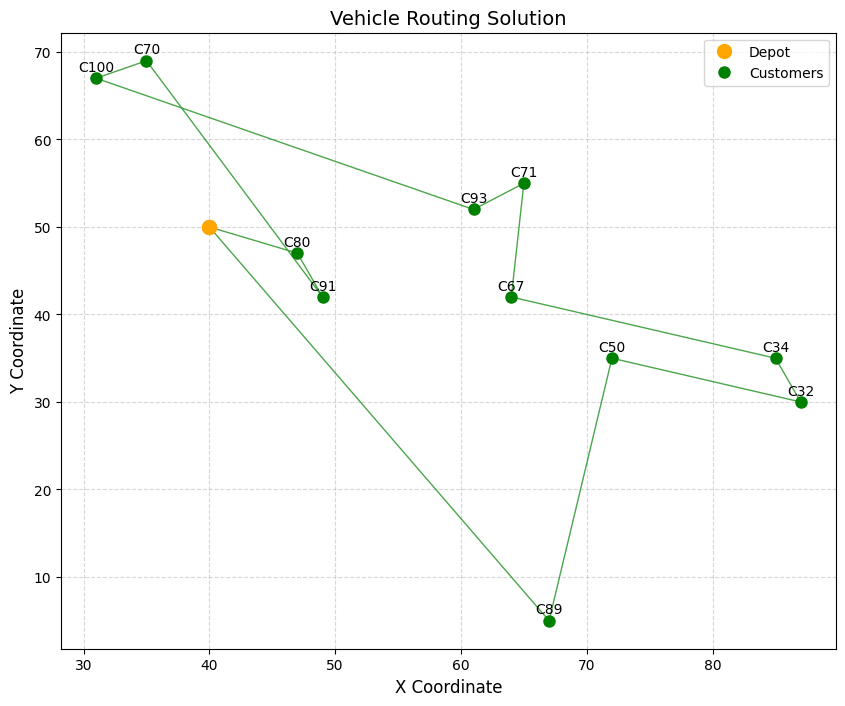

In [ ]:
# Sử dụng hàm solve_with_time

filenames = ['c101.txt', 'r101.txt', 'rc101.txt']
for i, filename in enumerate(filenames):
    depot, customers, vehicles, travel_times = get_params(filename)
    best_route, feasible_time, feasible_cap = test_ACO('solve_with_time', depot, customers, vehicles, travel_times)

    while (not feasible_time or not feasible_cap):
        best_route = aco_solver.solve(depot, customers, vehicles, travel_times)
        feasible_time = check_time(best_route, customers, travel_times)
        feasible_cap = check_capacity(best_route, customers, vehicles)

    print(best_route[0][0], end="")
    for route in best_route:
        print(f"-> {str(route[1])}", end="")

    plot_route(best_route, customers, depot)